# Classificação de vértices utilizando GCNs: rede CORA

In [ ]:
#Recria o grafo da rede CORA
url = 'https://raw.githubusercontent.com/luizalober/doc-disciplinas/main/redes-comp-2s2022/data/artigo/cora/cora.edges'
data = rq.get(url).content
G_cora = nx.read_weighted_edgelist(BytesIO(data), delimiter=',', create_using=nx.Graph(), nodetype=int)

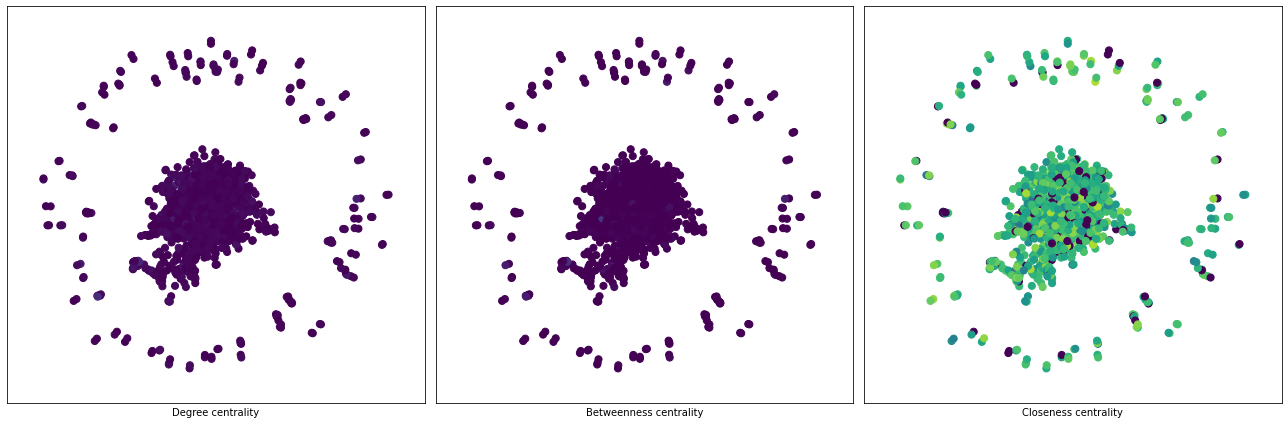

In [ ]:
#Desenha o grafo de acordo com as centralidades que serão posteriormente estudadas.
GraficaPorCentralidade(G_cora)

Esse trabalho de classificação de vértices será aplicado na rede CORA, de onde os dados para execução do modelo foram retirados de https://linqs.org/datasets/#cora

Cada vértice representa um artigo na rede de citações, que está dividida entre as categorias:

*  Estudos baseados em casos (case based);
*  Algoritmos genéticos;
*  Redes neurais;
*  Métodos probabilísticos;
*  Aprendizado reforçado (reinforced learning);
*  Aprendizado de regras;
*  Teoria.

onde cada conexão representa uma citação.

Temos um total de **1433** *features* para os 2708 vértices, formadas através da escolha de palavras com ao menos 10 repetições por texto e da remoção de *stopwords* do texto de cada um dos artigos.

Este grafo será tratado como não-direcionado.

## Configuraçoes

IMPORTANTE: rode `!pip install spektral` e `!pip install shap` se essa for a primeira vez rodando esse notebook.

In [5]:
#Configura as dependências do modelo

#-> Gerais
import numpy as np
import os
import networkx as nx
import pandas as pd
import scipy.sparse as sp
import requests as rq
from io import BytesIO

#-> 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve
from spektral.layers import GeneralConv
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2

#-> Visualização das features
from collections import Counter
from sklearn.manifold import TSNE

#-> Aplicação da Random Forest e feature importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

## Funções

Comentários em inglês indicam funções que foram adaptadas do meu código utilizado no trabalho de doutorado.

### Cálculos

In [18]:
def ApplyRFFeatureImportance(data, features_from_data, metric, size_test=0.25, estimators=50, random_state=42):
  '''
  -> data: DataFrame generated using one of the functions implemented to run SINDy
  -> features_from_data: features to test in this regressor
  -> metric: "target" for the random forest algorithm (array from original dataframe).
  -> size_test: for the train_test_split() function. Default: 0.25
  -> estimators: number of leaves to use. Default: 50
  -> random_state: can be anything. Default: sim_par.set_seed
  '''

  X = data[features_from_data]
  y = np.ravel(metric) 

  rf = RandomForestRegressor()
  rf.fit(X, y)

  perm_importance = permutation_importance(rf, X, y)

  return rf, perm_importance

def PlotFeatures(regressor):
  colors = sns.color_palette("flare", int(len(regressor.feature_importances_)+1))
  rank = list(range(0, len(regressor.feature_names_in_), 1))

  sorted_idx = (-regressor.feature_importances_).argsort()
  sns.barplot(regressor.feature_importances_[sorted_idx],regressor.feature_names_in_[sorted_idx], palette=np.array(colors[::-1])[rank])
  plt.xlabel("Random Forest Feature Importance")

def PlotPermutationImportance(regressor, perm_importance):
  colors = sns.color_palette("flare", int(len(regressor.feature_importances_)+1))
  rank = list(range(0, len(regressor.feature_names_in_), 1))

  sorted_idx = (-perm_importance.importances_mean).argsort()
  sns.barplot(perm_importance.importances_mean[sorted_idx], regressor.feature_names_in_[sorted_idx],  palette=np.array(colors[::-1])[rank])
  plt.xlabel("Permutation Based Feature Importance")

In [19]:
def acc(G):
  '''
  Calcula a acessibilidade de um grafo G.
  '''
  vk = dict(G.degree())
  vk = list(vk.values())
  A = nx.adjacency_matrix(G)
  N = len(G)
  P = np.zeros((N,N), dtype = 'float')
  for i in np.arange(0, N):
    for j in np.arange(0, N):
      if(vk[i] > 0):
        P[i,j] = A[i,j]/vk[i]
  P2 = sp.linalg.expm(P)/np.exp(1)
  vacc = np.zeros(N, dtype = float)
  for i in np.arange(0, N):
    acc = 0
    for j in np.arange(0,N):
      if(P2[i,j] > 0):
        acc = acc + P2[i,j]*np.log(P2[i,j])
    acc = np.exp(-acc)
    vacc[i] = acc

  return vacc

In [20]:
def degree_distribution(G):
  '''
  Calculate the probability of finding a node with degree k on a given graph.
  -> To plot this distribution, see PlotDegree() on "Ploting and visualization"
  '''
  vk = dict(G.degree())
  vk = list(vk.values())  # we get only the degree values
  vk = np.array(vk)
  maxk = np.max(vk)
  mink = np.min(vk)
  kvalues= np.arange(0,maxk+1) # possible values of k
  Pk = np.zeros(maxk+1) # P(k)
  for k in vk:
    Pk[k] = Pk[k] + 1
  Pk = Pk/sum(Pk) # the sum of the elements of P(k) must be equal to one
  return kvalues,Pk

def PlotDegree(ks, Pk):
  '''
  Plots the degree distribution using the results calculated by the 
  degree_distribution() function
  '''
  plt.figure(figsize=(8,5))
  fig = plt.subplot(1,1,1)
  plt.bar(ks,Pk)
  plt.xlabel("k", fontsize=20)
  plt.ylabel("P(k)", fontsize=20)
  plt.yscale("log")
  plt.title("Distribuição de grau", fontsize=20)
  plt.show(True)

### Gráficos

In [21]:
def PlotGraph(graph):
  '''
  Simple visualization for the graph obtained using GenerateKuramotoOutput()
  -> graph: output from NetworkX
  All other parameters from nx.draw() are adequate for small (n<100) graphs
  '''
  plt.figure(figsize=(8,8))
  pos=nx.spring_layout(graph)      
  nx.draw(graph, with_labels = False, node_size=50, font_size=16, pos = pos, edgecolors = "lightgray")
  plt.show(True)

In [22]:
def GraficaPorCentralidade(rede):
  '''
  Inputs:
  -> rede = Grafo do NetworkX
  Esta função permite fazer o gráfico através dos valores de centralidade calculados
  para uma dada rede, com valores de centralidade variáveis sendo indicados por cores
  (mais central: cores mais quentes).
  '''
  
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 6))

  #calcula as centralidades
  dcent = nx.degree_centrality(rede)
  bcent = nx.betweenness_centrality(rede)
  ccent = nx.closeness_centrality(rede)  

  #cria as cores para cada tipo de cálculo de centralidade
  color1 = [dcent.get(i) for i in range(len(dcent))]
  color2 = [bcent.get(i) for i in range(len(bcent))]
  color3 = [ccent.get(i) for i in range(len(ccent))]

  #Monta os gráficos
  pos=nx.spring_layout(rede)
  
  nx.draw(rede, pos, with_labels=False, node_size=50, node_color=color1, width=0.05, ax=ax1)
  ax1.set_axis_on() # turns on axis, bugfix 
  ax1.set_xlabel('Degree centrality')

  nx.draw(rede, pos, with_labels=False, node_size=50, node_color=color2, width=0.05, ax=ax2)
  ax2.set_axis_on() # turns on axis, bugfix
  ax2.set_xlabel('Betweenness centrality')

  nx.draw(rede, pos, with_labels=False, node_size=50, node_color=color3, width=0.05, ax=ax3)
  ax3.set_axis_on() # turns on axis, bugfix
  ax3.set_xlabel('Closeness centrality')

  fig.tight_layout()

  plt.show()

In [23]:
def PlotPrecision(data, metric):
  '''
  Mostra um gráfico de barras comparando a precisão de cada uma das classes.
  '''
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

  colors = sns.color_palette("hls", int(len(data[metric])))  #cria o número de cores baseado no número de partições
  sns.barplot(data.index, data[metric], palette=np.array(colors))
  ax.tick_params(axis='x', rotation=45)

  ax.set_ylabel('Precisão')

  plt.show()

In [24]:
def PlotMetricandProperties(tests, metric, data):
  '''
  -> tests: network properties being tested (str)
  ---> names must match those from the dataframe!
  -> metric: ML metric being used (str)
  '''
  labels = []    
  #Plot results side-by-side:
  fig, axs = plt.subplots(nrows=1, ncols=len(tests), figsize=(20, 7))

  colors = sns.color_palette("hls", int(len(data[metric])))

  for i in range(0, len(tests), 1):
    labels.append(str(tests[i]))
    data_swp = data.sort_values(by=tests[i])
    sort_colors = np.argsort(data[tests[i]])
    novas_cores = []

    for n in sort_colors:
      novas_cores.append(colors[n])

    #colors = sns.color_palette("hls", int(len(data_swp[tests[i]])+1))  #cria o número de cores baseado no número de partições
    #colors=np.array(colors)

    rank = list(range(0, len(data_swp[tests[i]]), 1))
    sns.barplot(data_swp[tests[i]], data_swp[metric], palette=np.array(novas_cores), ax=axs[i]);
    #axs[i].set_xlabel(labels[i])
    xlabels = ['{:,.5f}'.format(x) for x in data_swp[tests[i]]]
    axs[i].set_xticklabels(xlabels)

  #Especificamente para esse estudo: configura melhor as legendas do eixo x
  axs[0].set_xlabel("Centralidade de grau por classe")
  axs[1].set_xlabel("Assortatividade de grau por classe")
  axs[2].set_xlabel("Centralidade de intermediação por classe")
  
  for i in range(3):
    axs[i].set_ylabel('Precisão')

  plt.show()

In [25]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()

### Processamento de dados

In [26]:
def GetGraphCharacteristics(graph):

  #network features
  degree_cent = []
  between_cent = []
  close_cent = []
  avg_nb_degree = []
  node_degree_vec = []

  swp_dc = nx.degree_centrality(graph)
  swp_bc = nx.betweenness_centrality(graph)
  swp_cb = nx.closeness_centrality(graph)

  for node in (graph.nodes):
    node_degree_vec.append(nx.degree(graph, node))
    #Calculate some centrality measures
    degree_cent.append( swp_dc.get(node) )
    between_cent.append( swp_bc.get(node) )
    close_cent.append( swp_cb.get(node) )

  #Computes the accessibility of each node in this graph and save results
  acc_graph = acc(graph)

  #Also, computes the clustering coefficients for each node
  clustering_coeff = list(nx.clustering(graph).values())

  #Lastly, get the average degree of the neighborhood of each node
  for i in graph.nodes():
    aux =  nx.average_neighbor_degree(graph, nodes = [i])
    avg_nb_degree.append(float(aux[i]))
  avg_nb_degree = np.array(avg_nb_degree)

  res_columns = np.arange(0, len(graph), 1) #rewrite columns to create dataframe

  d = { 'node_degree': node_degree_vec, 'degree_cent': degree_cent, 
       'betweeness_cent':between_cent, 'closeness_cent': close_cent, 'accessibility': acc_graph,
       'clustering': clustering_coeff, 'avg_degree_neighbors': avg_nb_degree}

  df = pd.DataFrame(data=d)
  df.index = res_columns

  return df

In [27]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx

In [28]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

In [29]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix.
    De: https://github.com/tkipf/gcn/blob/master/gcn/utils.py
    """
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    adj_normalized = adj_normalized.transpose()
    return adj_normalized

# Modelo

### Carrega os dados e faz o pré-processamento. 


In [11]:
#Carrega os dados
#-> Mude a pasta local indicada para a sua.
#-> Alternativamente, os dados estão disponíveis em https://github.com/luizalober/doc-disciplinas/tree/main/redes-comp-2s2022/data/artigo/cora

all_data = []
all_edges = []


for root,dirs,files in os.walk("/cora"):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif '.cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

                
#Randomiza os dados, já que há uma ordenação por categorias.
random_state = 77
all_data = shuffle(all_data,random_state=random_state)

## Analisando os dados

In [13]:
#parse the data
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0]    #Número de vértices
F = X.shape[1]    #Tamanho do dicionário de features
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNúmero de vértices (N): ', N)
print('\nNúmero de features (F) para cada vértice: ', F)
print('\nCategorias: ', set(labels))

num_classes = len(set(labels))
print('\nNúmero de classes: ', num_classes)

X shape:  (2708, 1433)

Número de vértices (N):  2708

Número de features (F) para cada vértice:  1433

Categorias:  {'Theory', 'Case_Based', 'Rule_Learning', 'Neural_Networks', 'Reinforcement_Learning', 'Probabilistic_Methods', 'Genetic_Algorithms'}

Número de classes:  7


### Separa os conjuntos de treino, validação e teste.

In [30]:
train_idx,val_idx,test_idx = limit_data(labels)

In [31]:
#Configura a máscara: ela é utilizada para de fato separar os dados em conjuntos
#dada a estrutura de matrizes em que estes estão contidos.

train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

### Mostra a distribuição de dados

In [14]:
print("Distribuição de todos os dados: \n{}".format(Counter(labels)))

Distribuição de todos os dados: 
Counter({'Neural_Networks': 818, 'Probabilistic_Methods': 426, 'Genetic_Algorithms': 418, 'Theory': 351, 'Case_Based': 298, 'Reinforcement_Learning': 217, 'Rule_Learning': 180})


In [32]:
print("Distribuição dos dados de treino: \n{}".format(Counter([labels[i] for i in train_idx])))

Distribuição dos dados de treino: 
Counter({'Reinforcement_Learning': 20, 'Probabilistic_Methods': 20, 'Neural_Networks': 20, 'Case_Based': 20, 'Theory': 20, 'Genetic_Algorithms': 20, 'Rule_Learning': 20})


In [33]:
print("Distribuição dos dados de validação: \n{}".format(Counter([labels[i] for i in val_idx])))

Distribuição dos dados de validação: 
Counter({'Neural_Networks': 172, 'Genetic_Algorithms': 78, 'Probabilistic_Methods': 72, 'Theory': 63, 'Case_Based': 58, 'Reinforcement_Learning': 35, 'Rule_Learning': 22})


### Aplica one-hot encoding

In [34]:
labels_encoded, classes = encode_label(labels)

### Constrói o grafo através do pacote NetworkX utilizando os vértices e arestas obtidos:

In [35]:
#build the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Informação sobre o grafo: ', nx.info(G))

Informação sobre o grafo:  Graph with 2708 nodes and 5278 edges


### Aplica a normalização simétrica 

In [ ]:
A = preprocess_adj(A)

## Constrói e compila a GCN

In [ ]:
#Parâmetros
channels = 16           # Número de canais na primeira camada
dropout = 0.5           # Taxa de dropout para as features
l2_reg = 5e-4           # Taxa de regularizaçao L2
learning_rate = 1e-2    # Taxa de aprendizado (learning rate)
epochs = 200            # Número de épocas para aplicar o treino
es_patience = 10        # Paciência para "early stopping"

#Operações de pré-processamento do modelo
A = GeneralConv.preprocess(A).astype('f4')

#Definição do modelo
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GeneralConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GeneralConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

#Compila o modelo
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

2022-11-26 11:02:37.863283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 11:02:37.863994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-26 11:02:37.864080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-26 11:02:37.864148: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-26 11:02:37.864213: W tensorflow/c

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1433)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2708)]       0           []                               
                                                                                                  
 general_conv (GeneralConv)     (None, 16)           22992       ['dropout[0][0]',                
                                                                  'input_2[0][0]']            

In [ ]:
#Treina o modelo
validation_data = ([X, A], labels_encoded, val_mask)
cora_results = model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.1191 - acc: 0.1571 - val_loss: 0.3779 - val_acc: 0.2680
Epoch 2/200
1/1 [==============================] - 0s 62ms/step - loss: 0.1046 - acc: 0.3500 - val_loss: 0.3443 - val_acc: 0.3480
Epoch 3/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0900 - acc: 0.5071 - val_loss: 0.3227 - val_acc: 0.4060
Epoch 4/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0819 - acc: 0.6786 - val_loss: 0.3056 - val_acc: 0.4580
Epoch 5/200
1/1 [==============================] - 0s 62ms/step - loss: 0.0811 - acc: 0.6714 - val_loss: 0.2925 - val_acc: 0.5060
Epoch 6/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0710 - acc: 0.8143 - val_loss: 0.2827 - val_acc: 0.5620
Epoch 7/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0717 - acc: 0.8000 - val_loss: 0.2749 - val_acc: 0.6280
Epoch 8/200
1/1 [==============================] - 0s 61ms/step - loss: 0.0713 - acc: 0.7929

In [ ]:
#Salva os resultados do treino num arquivo .CSV
pd.DataFrame(cora_results.history['acc']).to_csv("results-CORA-acc-val.csv") 

In [ ]:
#Avalia o modelo
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes, output_dict=True)
print('GCN Classification Report: \n {}'.format(report))

1/1 [==============================] - 0s 95ms/step
GCN Classification Report: 
 {'Case_Based': {'precision': 0.8823529411764706, 'recall': 0.6578947368421053, 'f1-score': 0.7537688442211056, 'support': 114}, 'Genetic_Algorithms': {'precision': 0.8780487804878049, 'recall': 0.23076923076923078, 'f1-score': 0.3654822335025381, 'support': 156}, 'Neural_Networks': {'precision': 0.652014652014652, 'recall': 0.6137931034482759, 'f1-score': 0.6323268206039077, 'support': 290}, 'Probabilistic_Methods': {'precision': 0.31934731934731936, 'recall': 0.7965116279069767, 'f1-score': 0.4559068219633944, 'support': 172}, 'Reinforcement_Learning': {'precision': 0.8852459016393442, 'recall': 0.6352941176470588, 'f1-score': 0.7397260273972602, 'support': 85}, 'Rule_Learning': {'precision': 0.72, 'recall': 0.6, 'f1-score': 0.6545454545454547, 'support': 60}, 'Theory': {'precision': 0.7868852459016393, 'recall': 0.3902439024390244, 'f1-score': 0.5217391304347827, 'support': 123}, 'accuracy': 0.564, 'macr

In [ ]:
#Mostra os resultados acima
#-> output_dict=True faz necessário o uso desse dataframe,
#-> além dele e do vetor `report` serem posteriormente úteis nos cálculos
df_GCN = pd.DataFrame(report).transpose()
df_GCN

,precision,recall,f1-score,support
Case_Based,0.882353,0.657895,0.753769,114.000
Genetic_Algorithms,0.878049,0.230769,0.365482,156.000
Neural_Networks,0.652015,0.613793,0.632327,290.000
Probabilistic_Methods,0.319347,0.796512,0.455907,172.000
Reinforcement_Learning,0.885246,0.635294,0.739726,85.000
Rule_Learning,0.720000,0.600000,0.654545,60.000
Theory,0.786885,0.390244,0.521739,123.000
accuracy,0.564000,0.564000,0.564000,0.564
macro avg,0.731985,0.560644,0.589071,1000.000
weighted avg,0.696809,0.564000,0.571059,1000.000


In [ ]:
#Salva a tabela acima no formato .CSV
df_GCN.to_csv("results-CORA-p-r-f1-sup.csv")

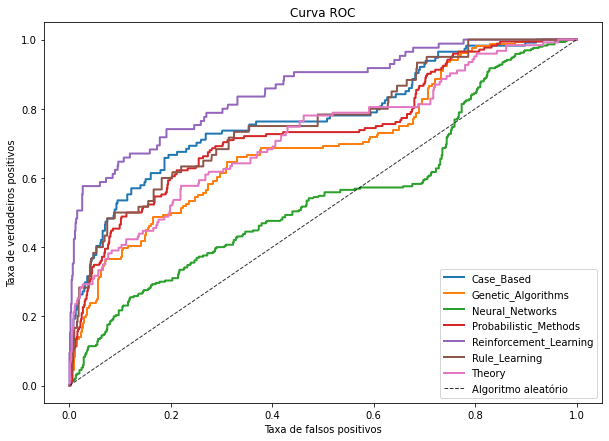

In [ ]:
#Cria a curva ROC para este modelo

fpr = dict()
tpr = dict()
classes = df_GCN.index[:-3]

plt.figure(figsize=(10,7))
for i in range(len(df_GCN.index)-3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i],
                                  y_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label=classes[i])
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k',
             label='Algoritmo aleatório', alpha=.8) # Predição aleatória (50/50)

plt.xlabel("Taxa de falsos positivos")
plt.ylabel("Taxa de verdadeiros positivos")
plt.legend(loc="best")
plt.title("Curva ROC")
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


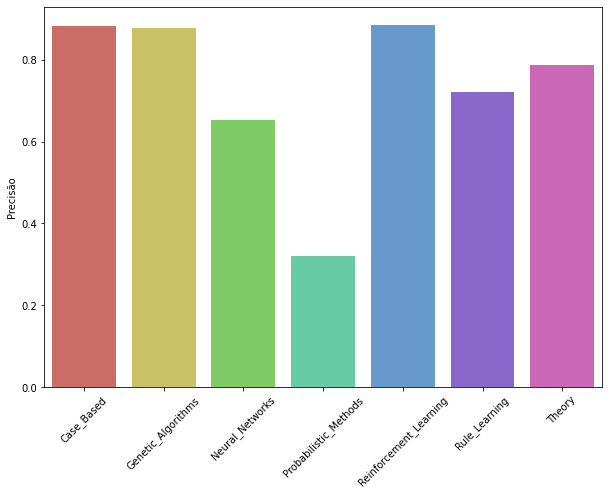

In [ ]:
#Gráfico da precisão do modelo para cada categoria
PlotPrecision(data=df_GCN[:-3], metric='precision')

## Cria a representação das ativações das *hidden layers* para este modelo

O algoritmo utilizado para isto é o t-SNE.
Mais informações sobre ele estão disponíveis em: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Mostra a representação para a primeira camada da GCN
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

1/1 [==============================] - 0s 132ms/step


/home/llober/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/llober/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


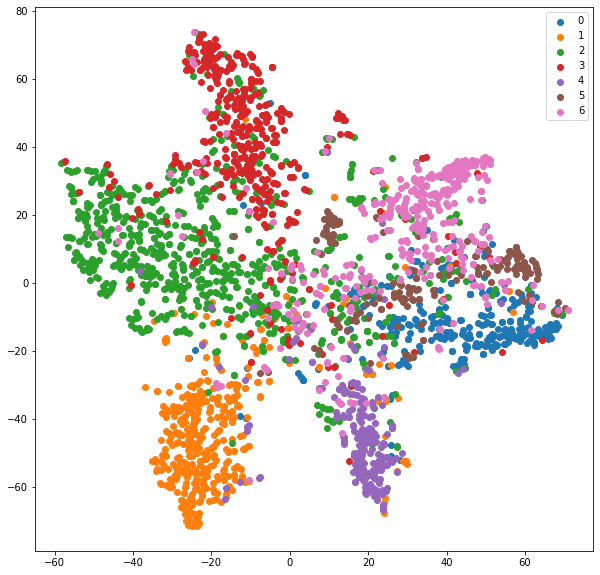

In [ ]:
plot_tSNE(labels_encoded,x_tsne)

# Análise das propriedades de cada subrede

Aqui, utilizo os dados de http://networkrepository.com/ por conta de ser mais difícil extrair as labels através das entradas de .contents.
O que muda entre estes dois conjuntos de dados é somente a formatação da rede.

In [ ]:
#Importa as categoriais para a rede CORA.
url = 'https://raw.githubusercontent.com/luizalober/doc-disciplinas/main/redes-comp-2s2022/data/artigo/cora/cora.node_labels'
data = rq.get(url).content
labels_cora = pd.read_csv(BytesIO(data), names=['vertices', 'comunidade'])

In [ ]:
labels_cora

,vertices,comunidade
0,1,3
1,2,6
2,3,5
3,4,5
4,5,4
...,...,...
2703,2704,2
2704,2705,2
2705,2706,2
2706,2707,1


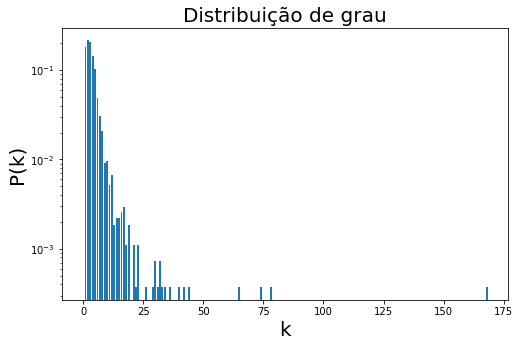

In [ ]:
ks, Pk = degree_distribution(G_cora)
PlotDegree(ks, Pk)

In [ ]:
#Separa cada comunidade em subgrafos

subgrafos = []

for i in list(set(labels_cora.comunidade)):
  swp = labels_cora.loc[labels_cora['comunidade'] == i]
  subgrafos.append(G_cora.subgraph(list(swp.vertices)))

## Aplica a função GetGraphCharacteristics() para todos os subgrafos (classes) da rede CORA:

In [ ]:
df_com_0 = GetGraphCharacteristics(subgrafos[0])
df_com_1 = GetGraphCharacteristics(subgrafos[1])
df_com_2 = GetGraphCharacteristics(subgrafos[2])
df_com_3 = GetGraphCharacteristics(subgrafos[3])
df_com_4 = GetGraphCharacteristics(subgrafos[4])
df_com_5 = GetGraphCharacteristics(subgrafos[5])
df_com_6 = GetGraphCharacteristics(subgrafos[6])

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [ ]:
#Concatena todos os resultados acima
df_res = []
df_res = pd.concat((df_com_0.mean(), df_com_1.mean(), df_com_2.mean(), df_com_3.mean(), df_com_4.mean(), df_com_5.mean(), df_com_6.mean()), axis=1)

In [ ]:
df_res = df_res.transpose()
df_res

,node_degree,degree_cent,betweeness_cent,closeness_cent,accessibility,clustering,avg_degree_neighbors
0,2.798658,0.009423,0.011201,0.114324,5.492377,0.192974,4.650048
1,3.956938,0.009489,0.005486,0.262010,8.278068,0.313184,22.863630
2,2.872861,0.003516,0.003866,0.101701,5.758976,0.216936,8.707701
3,3.098592,0.007291,0.008262,0.094916,5.800104,0.240269,4.819086
4,3.769585,0.017452,0.007244,0.207580,7.657503,0.265400,12.280366
5,2.811111,0.015705,0.005757,0.091283,5.228925,0.269359,5.203930
6,3.042735,0.008694,0.008275,0.131030,6.067265,0.194438,5.357806


Renomeia o índice

In [ ]:
df_res.rename(index={0: 'Case_Based'}, inplace=True)
df_res.rename(index={1: 'Genetic_Algorithms'}, inplace=True)
df_res.rename(index={2: 'Neural_Networks'}, inplace=True)
df_res.rename(index={3: 'Probabilistic_Methods'}, inplace=True)
df_res.rename(index={4: 'Reinforcement_Learning'}, inplace=True)
df_res.rename(index={5: 'Rule_Learning'}, inplace=True)
df_res.rename(index={6: 'Theory'}, inplace=True)
df_res

,node_degree,degree_cent,betweeness_cent,closeness_cent,accessibility,clustering,avg_degree_neighbors
Case_Based,2.798658,0.009423,0.011201,0.114324,5.492377,0.192974,4.650048
Genetic_Algorithms,3.956938,0.009489,0.005486,0.262010,8.278068,0.313184,22.863630
Neural_Networks,2.872861,0.003516,0.003866,0.101701,5.758976,0.216936,8.707701
Probabilistic_Methods,3.098592,0.007291,0.008262,0.094916,5.800104,0.240269,4.819086
Reinforcement_Learning,3.769585,0.017452,0.007244,0.207580,7.657503,0.265400,12.280366
Rule_Learning,2.811111,0.015705,0.005757,0.091283,5.228925,0.269359,5.203930
Theory,3.042735,0.008694,0.008275,0.131030,6.067265,0.194438,5.357806


Agora, guarda a assortatividade de cada uma dessas subredes.
Este cálculo precisa ser realizado separadamente por conta do tamanho dos dataframes anteriores.

In [ ]:
as_coeff = []
for grafo in subgrafos:
  as_coeff.append(nx.degree_assortativity_coefficient(grafo))
a_coeff = pd.DataFrame(data=as_coeff, index=df_res.index, columns=['degree_assortativity'])

df_res = df_res.join(a_coeff)
df_res

,node_degree,degree_cent,betweeness_cent,closeness_cent,accessibility,clustering,avg_degree_neighbors,degree_assortativity
Case_Based,2.798658,0.009423,0.011201,0.114324,5.492377,0.192974,4.650048,-0.125557
Genetic_Algorithms,3.956938,0.009489,0.005486,0.262010,8.278068,0.313184,22.863630,-0.120901
Neural_Networks,2.872861,0.003516,0.003866,0.101701,5.758976,0.216936,8.707701,-0.131659
Probabilistic_Methods,3.098592,0.007291,0.008262,0.094916,5.800104,0.240269,4.819086,-0.028881
Reinforcement_Learning,3.769585,0.017452,0.007244,0.207580,7.657503,0.265400,12.280366,-0.181240
Rule_Learning,2.811111,0.015705,0.005757,0.091283,5.228925,0.269359,5.203930,-0.108433
Theory,3.042735,0.008694,0.008275,0.131030,6.067265,0.194438,5.357806,-0.013487


Guarda os erros para cada uma das classes:

In [ ]:
df_res = df_res.join(df_GCN)
df_res

,node_degree,degree_cent,betweeness_cent,closeness_cent,accessibility,clustering,avg_degree_neighbors,degree_assortativity,precision,recall,f1-score,support
Case_Based,2.798658,0.009423,0.011201,0.114324,5.492377,0.192974,4.650048,-0.125557,0.882353,0.657895,0.753769,114.0
Genetic_Algorithms,3.956938,0.009489,0.005486,0.262010,8.278068,0.313184,22.863630,-0.120901,0.878049,0.230769,0.365482,156.0
Neural_Networks,2.872861,0.003516,0.003866,0.101701,5.758976,0.216936,8.707701,-0.131659,0.652015,0.613793,0.632327,290.0
Probabilistic_Methods,3.098592,0.007291,0.008262,0.094916,5.800104,0.240269,4.819086,-0.028881,0.319347,0.796512,0.455907,172.0
Reinforcement_Learning,3.769585,0.017452,0.007244,0.207580,7.657503,0.265400,12.280366,-0.181240,0.885246,0.635294,0.739726,85.0
Rule_Learning,2.811111,0.015705,0.005757,0.091283,5.228925,0.269359,5.203930,-0.108433,0.720000,0.600000,0.654545,60.0
Theory,3.042735,0.008694,0.008275,0.131030,6.067265,0.194438,5.357806,-0.013487,0.786885,0.390244,0.521739,123.0


In [ ]:
df_res.to_csv("results-CORA-with_network_properties.csv")

# Resultados de classificação



## Feature importance

In [ ]:
fts = fts=['node_degree', 'degree_cent', 'betweeness_cent', 'closeness_cent', 'accessibility', 'clustering', 'avg_degree_neighbors', 'degree_assortativity']

rf, rf_perm = ApplyRFFeatureImportance(data=df_res, features_from_data=fts, metric=df_res['precision'], size_test=0.25, estimators=50, random_state=42)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


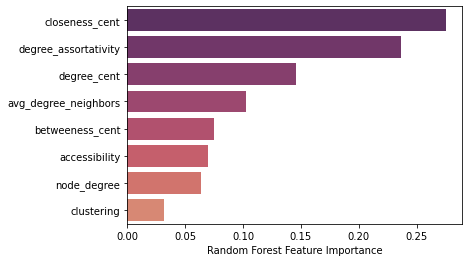

In [ ]:
PlotFeatures(rf)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


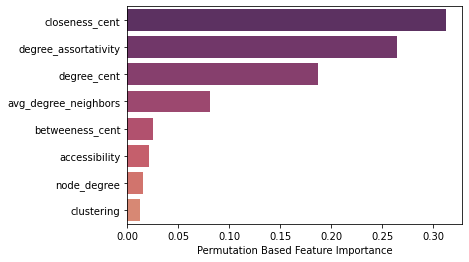

In [ ]:
PlotPermutationImportance(rf, rf_perm)

## Valores SHAP

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(df_res[fts])

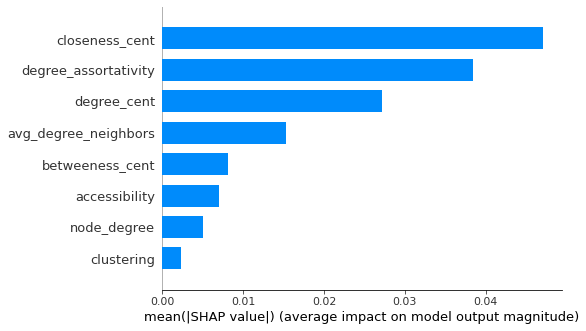

In [ ]:
shap.summary_plot(shap_values, df_res[fts], plot_type="bar")

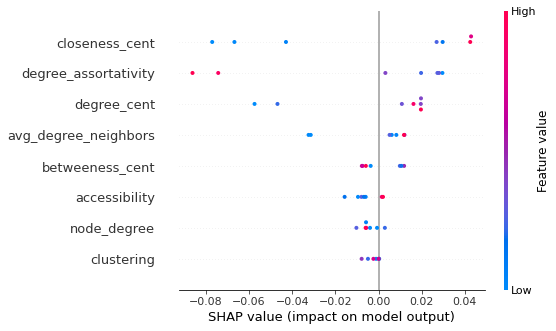

In [ ]:
shap.summary_plot(shap_values, df_res[fts])

## Precisão vs as 3 medidas mais importantes

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


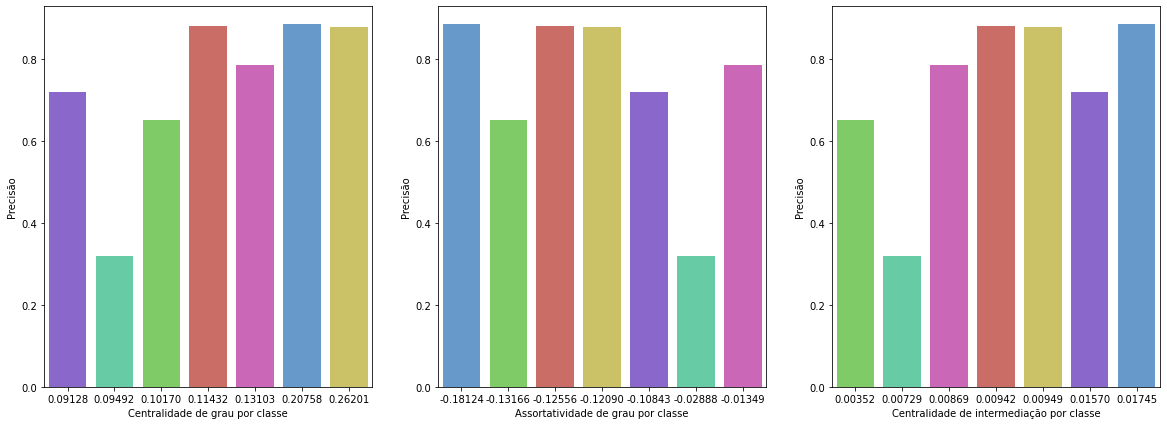

In [ ]:
prop_to_test = ['closeness_cent', 'degree_assortativity', 'degree_cent']

PlotMetricandProperties(tests=prop_to_test, metric='precision', data=df_res)